In [23]:
import os
import warnings
import time
# обработка данных
import pandas as pd
import numpy as np
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
# визуализация данных
import matplotlib.pyplot as plt
from tqdm import tqdm
# linear_model:
from sklearn.linear_model import LinearRegression, ARDRegression, BayesianRidge, ElasticNet, \
ElasticNetCV, GammaRegressor, HuberRegressor, Lars, LarsCV, LinearRegression, \
OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV, PassiveAggressiveRegressor, \
PoissonRegressor, QuantileRegressor, RANSACRegressor, SGDRegressor, TheilSenRegressor, \
TweedieRegressor
# lasso:
from sklearn.linear_model import Lasso, LassoCV, LassoLars, LassoLarsCV, LassoLarsIC
# ensemble:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, \
GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
# composition:
from sklearn.cross_decomposition import PLSRegression, CCA, PLSCanonical
from sklearn.compose import TransformedTargetRegressor
# special:
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
# neighbors:
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
# ridge:
from sklearn.linear_model import Ridge, RidgeCV
# svm:
from sklearn.svm import LinearSVR, NuSVR, SVR
# метрики точности моделей
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")

In [4]:
%%time
path = 'F:\\Output Datasets\\'
paths = os.listdir(path=path)
datasets = {file[-5:-6:-1]: pd.read_csv(path + file) for file in paths}
apr_days, may_days, dec_days, jan_days = [29, 30], [1, 6, 7, 8, 9], [29, 30, 31], [1, 2, 3, 4, 5, 6, 7, 8]
april, may, december, january = 4, 5, 12, 1
for dataset in datasets:
    data = datasets[dataset]
    data['DD'] = pd.to_datetime(data['DD'])
    data.drop(columns=['SSCL1', 'SEG_CLASS_CODE'], inplace=True)
    data['weekend'] = (data['DD'].dt.dayofweek > 4).astype(int) # 1 - выходной / 0 - рабочий
    data['dayOfWeek'] = data['DD'].dt.dayofweek # дни недели
    data['holidays'] = \
    ((data['DD'].dt.day.isin(apr_days)) & (data['DD'].dt.month == april)   | # праздник весны и труда
    (data['DD'].dt.day.isin(may_days)) & (data['DD'].dt.month == may)      | # 9 мая
    (data['DD'].dt.day.isin(dec_days)) & (data['DD'].dt.month == december) |  # предновогодние дни
    (data['DD'].dt.day.isin(jan_days)) & (data['DD'].dt.month == january))    # новогодние дни
    data['holidays'] = data['holidays'].astype(int)
    dd = data['DD'].apply(lambda x: x.value)
    data['DD'] = (dd - dd.mean()) / dd.std()

Wall time: 3min 43s


In [13]:
def train(model: BaseEstimator, dataset: pd.DataFrame, scores: tuple) -> tuple:
    score_train = {}
    score_test = {}
    X, y = dataset.drop(columns=['PASS_BK']), dataset['PASS_BK']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=100)
    start = time.time()
    model = model.fit(X_train, y_train)
    train_time = time.strftime("%H:%M:%S", time.gmtime(round(time.time() - start, 2)))
    y_train_pred = model.predict(X_train)
    start = time.time()
    y_test_pred = model.predict(X_test)
    test_time = time.strftime("%H:%M:%S", time.gmtime(round(time.time() - start, 2)))
    for score in scores:
        score_train[str(score).split()[1]] = round(score(y_train, y_train_pred), 4)
        score_test[str(score).split()[1]] = round(score(y_test, y_test_pred), 4)
    return train_time, score_train, score_test, test_time

def training_graph(models: list,
                   train_times: list, train_scores: dict,
                   test_times: list, test_scores: dict) -> None:
    metrics = tuple(train_scores[0].keys()) # кортеж всех метрик
    plt.style.use("seaborn")
    for i in range(len(train_scores[0])):
        test_score = np.clip([score[metrics[i]] for score in test_scores], 0, 1)
        plt.bar(models, np.clip([score[metrics[i]] for score in train_scores], 0, 1), width=.5,
                  label='train', alpha=.5, color='#78DBE2') # метрики для train
        plt.bar(models, test_score, width=.5, label='test', alpha=.8, color='#2dd29f') # метрики для test
        plt.title(metrics[i], pad=50, fontsize=22, fontname="Times New Roman")
        for j in range(len(models)):
            plt.text(j, 1.1, train_times[j], ha = 'center')
            time_n_acc = f'{test_times[j]}\n{test_scores[j][metrics[i]]}'
            plt.text(j, test_score[j], time_n_acc, ha='center')
        plt.ylim(0, 1.1)
        plt.xticks(models, rotation=45, fontsize=12, fontname="Times New Roman")
        plt.ylabel('Метрика', fontweight='bold', fontsize=18, fontname="Times New Roman")
        plt.legend(fontsize=14, loc='upper left')
        plt.show()

def train_models(classic_models: list) -> tuple:
    cycle = tqdm(classic_models)
    models, train_times, train_scores, test_times, test_scores = [], [], [], [], []
    for model in cycle:
        cycle.set_description(f"Тестирования {str(model)[:-2]}")
        try:
            result_training = train(model, datasets['C'], metrics)
            models.append(str(model))
            train_times.append(result_training[0])
            train_scores.append(result_training[1])
            test_scores.append(result_training[2])
            test_times.append(result_training[3])
        except Exception as e:
            print(e, str(model), 'не подходит под данные.')
            continue
    return models, train_times, train_scores, test_times, test_scores

In [15]:
metrics = (mean_absolute_error, r2_score)
# MAE - в среднем отклонение между реальным и предсказанным значениями (меньше - лучше)
# R2 - насколько данные соответсвуют модели (чем ближе к 1.0, тем лучше); > 80% идеал

In [11]:
linear_models = (LinearRegression(), ARDRegression(), BayesianRidge(), ElasticNet(),
ElasticNetCV(), Lars(), LarsCV(), OrthogonalMatchingPursuitCV(), PoissonRegressor())

In [39]:
models, train_times, train_scores, test_times, test_scores = train_models(linear_models)

Тестирования PoissonRegressor: 100%|█████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.43s/it]


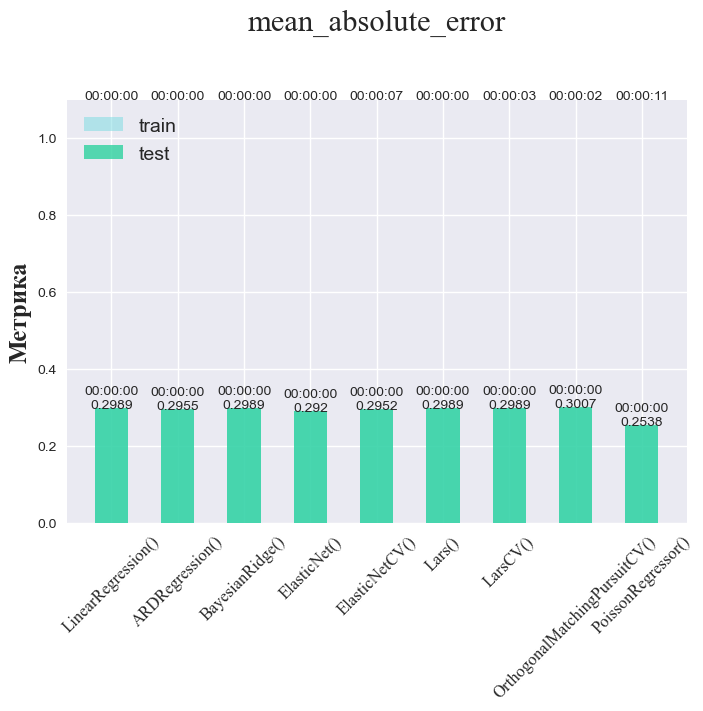

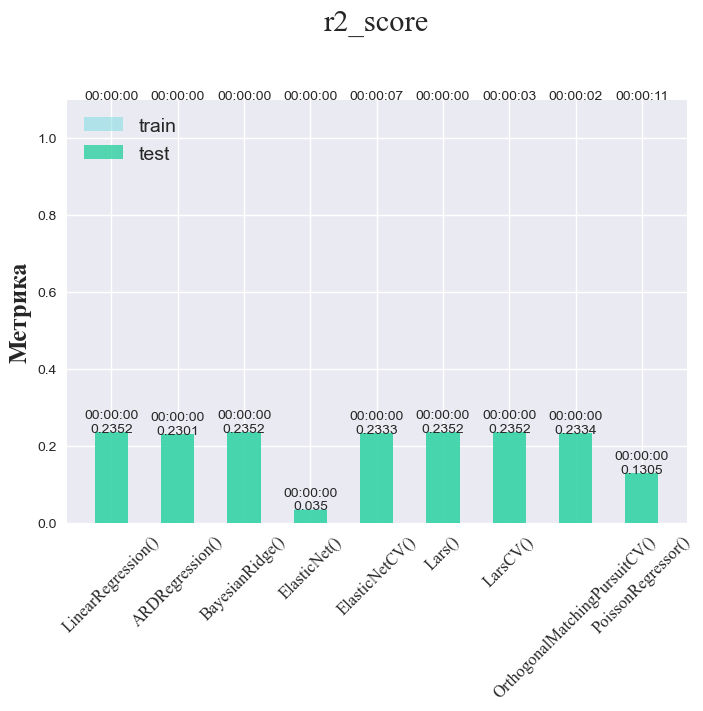

In [41]:
training_graph(models, train_times, train_scores, test_times, test_scores)

In [45]:
lasso_models = (Lasso(), LassoCV(), LassoLars(), LassoLarsCV(), LassoLarsIC())
models, train_times, train_scores, test_times, test_scores = train_models(lasso_models)

Тестирования LassoLarsIC: 100%|██████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.04s/it]


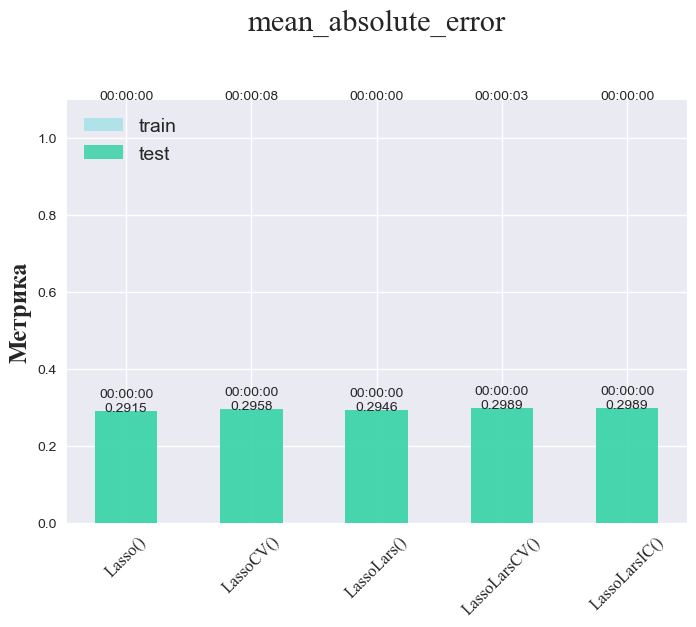

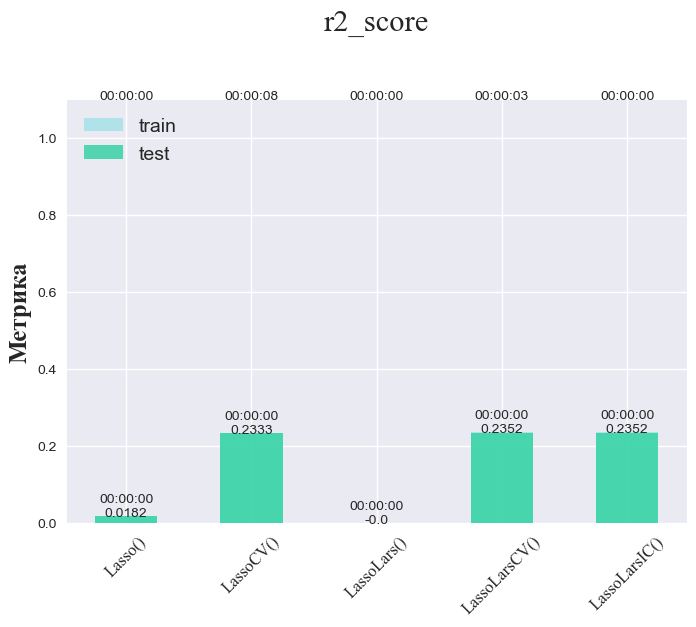

In [46]:
training_graph(models, train_times, train_scores, test_times, test_scores)

In [54]:
ensemlbe_models = (AdaBoostRegressor(), BaggingRegressor(), ExtraTreesRegressor(), 
                   GradientBoostingRegressor(), HistGradientBoostingRegressor(),
                   RandomForestRegressor())
models, train_times, train_scores, test_times, test_scores = train_models(ensemlbe_models)

Тестирования RandomForestRegressor: 100%|███████████████████████████████████████████████| 6/6 [15:59<00:00, 159.84s/it]


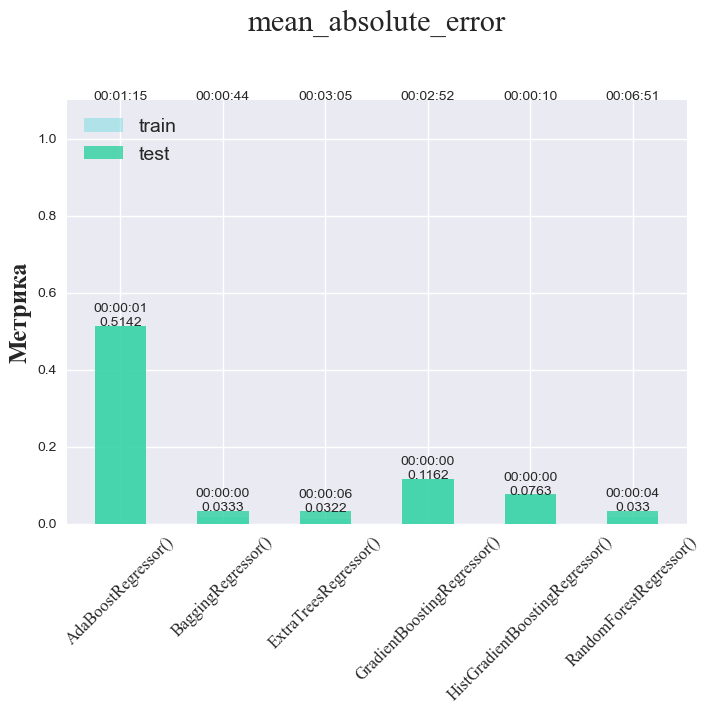

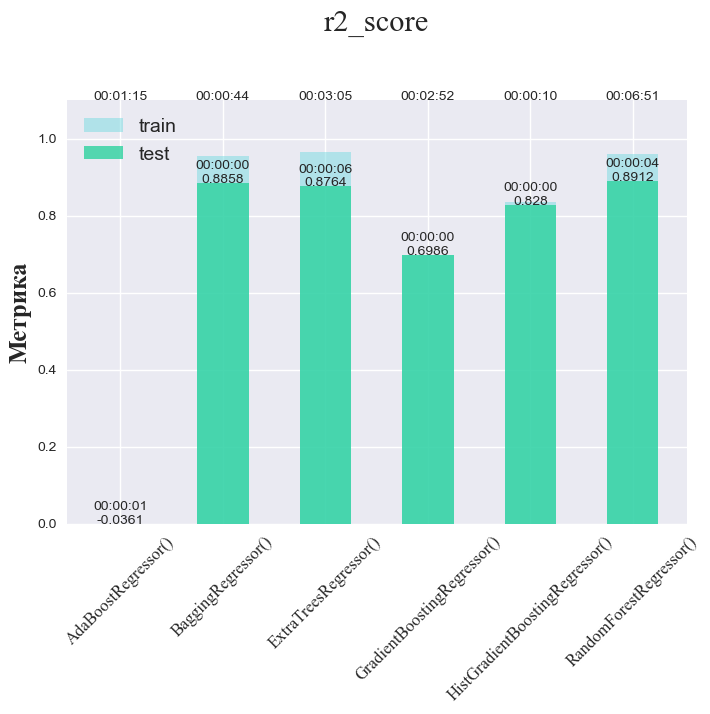

In [55]:
training_graph(models, train_times, train_scores, test_times, test_scores)

In [59]:
compose_models = (PLSRegression(), CCA(), PLSCanonical(), TransformedTargetRegressor())
models, train_times, train_scores, test_times, test_scores = train_models(compose_models)

Тестирования TransformedTargetRegressor: 100%|███████████████████████████████████████████| 4/4 [00:04<00:00,  1.06s/it]


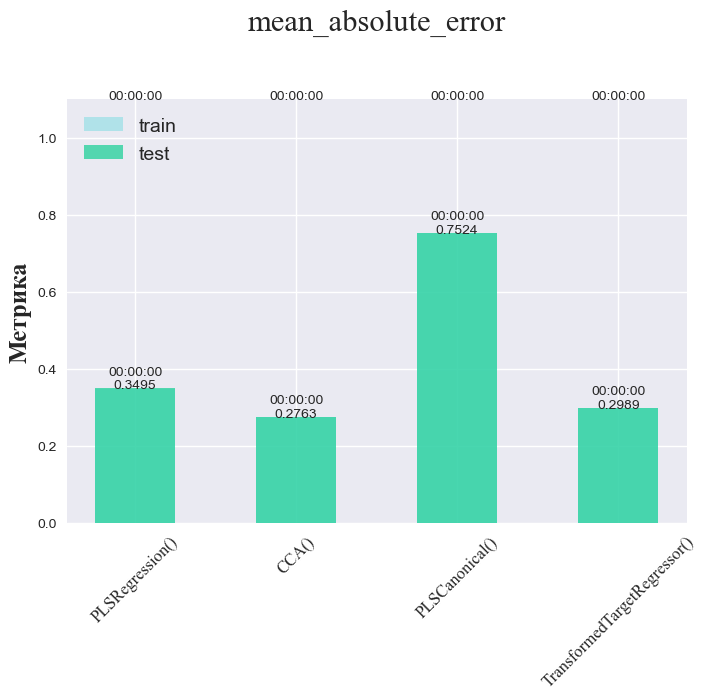

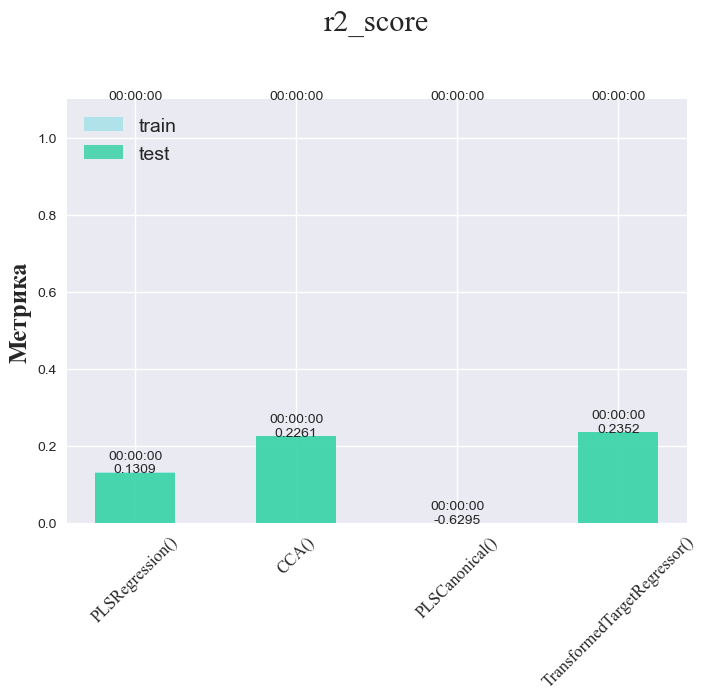

In [60]:
training_graph(models, train_times, train_scores, test_times, test_scores)

In [16]:
special_models = (DecisionTreeRegressor(), DummyRegressor())
models, train_times, train_scores, test_times, test_scores = train_models(special_models)

Тестирования DummyRegressor: 100%|███████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.44s/it]


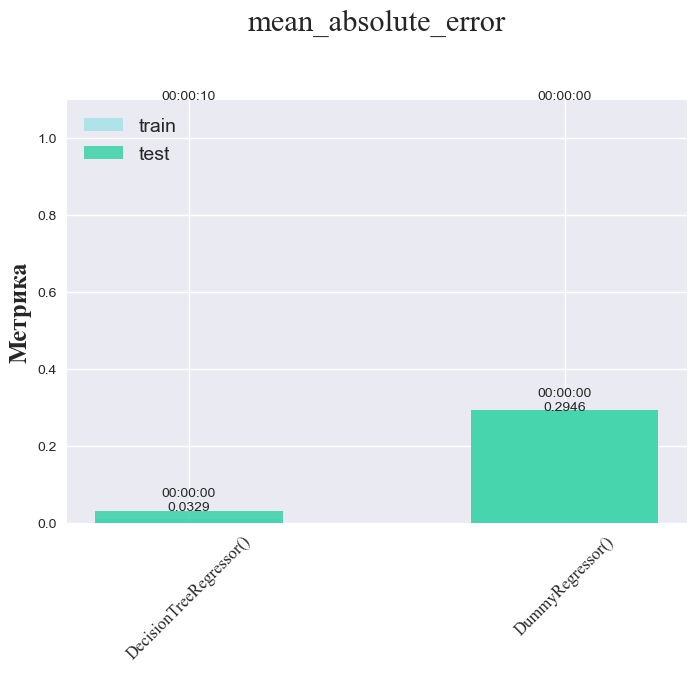

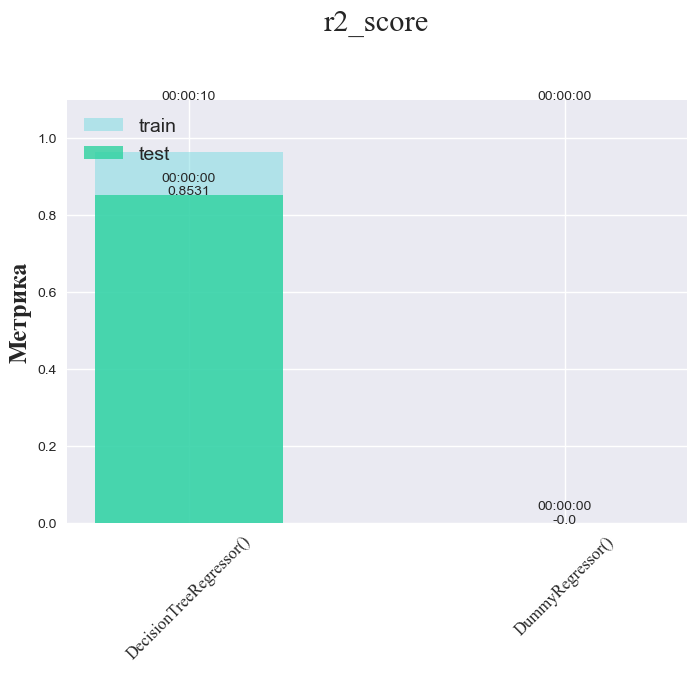

In [17]:
training_graph(models, train_times, train_scores, test_times, test_scores)

In [20]:
ridge_models = (Ridge(), RidgeCV())
models, train_times, train_scores, test_times, test_scores = train_models(ridge_models)

Тестирования KernelRidge: 100%|██████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.04s/it]

Unable to allocate 8.61 TiB for an array with shape (1087941, 1087941) and data type float64 KernelRidge() не подходит под данные.


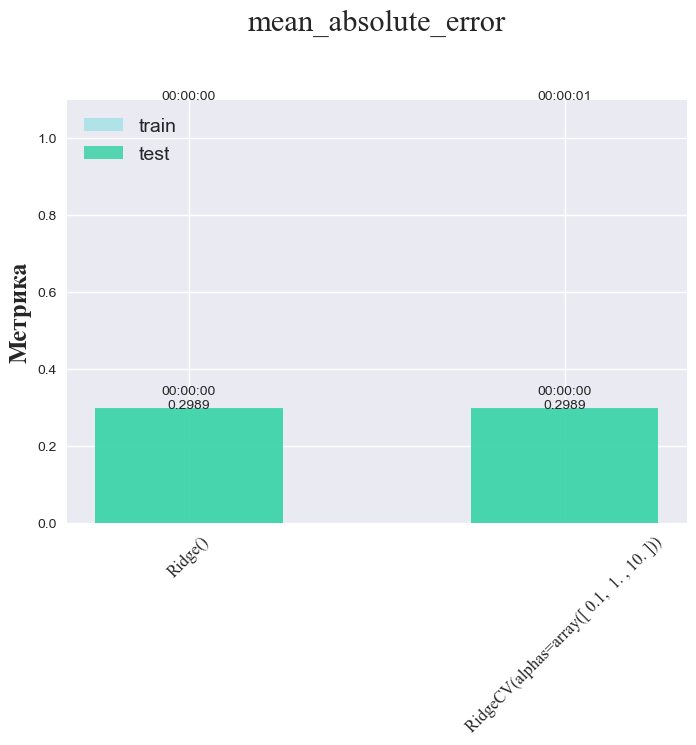

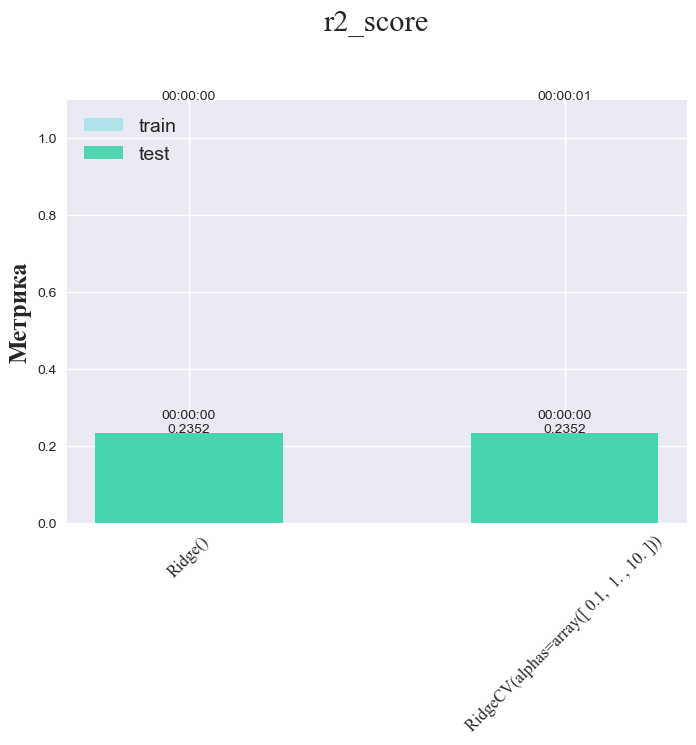

In [21]:
training_graph(models, train_times, train_scores, test_times, test_scores)

In [24]:
neighbors_models = (KNeighborsRegressor(), RadiusNeighborsRegressor())
models, train_times, train_scores, test_times, test_scores = train_models(neighbors_models)

Тестирования RadiusNeighborsRegressor: 100%|████████████████████████████████████████████| 2/2 [05:42<00:00, 171.39s/it]


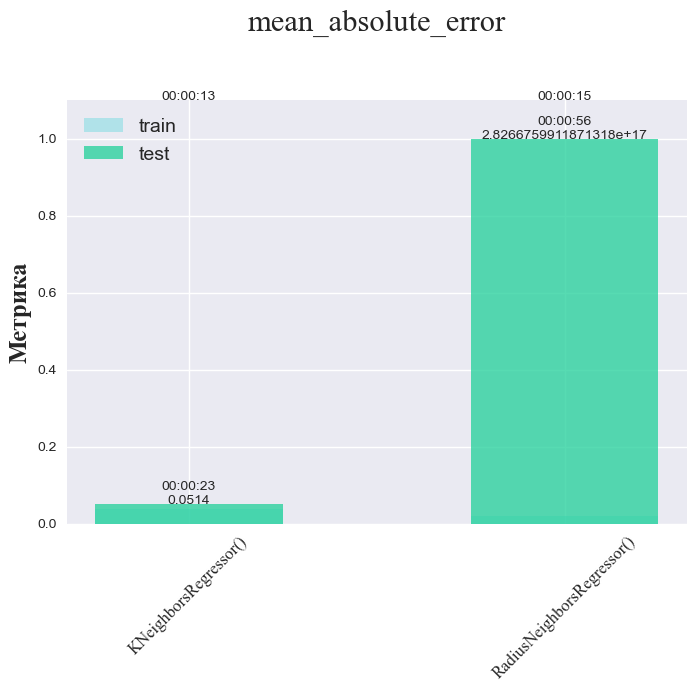

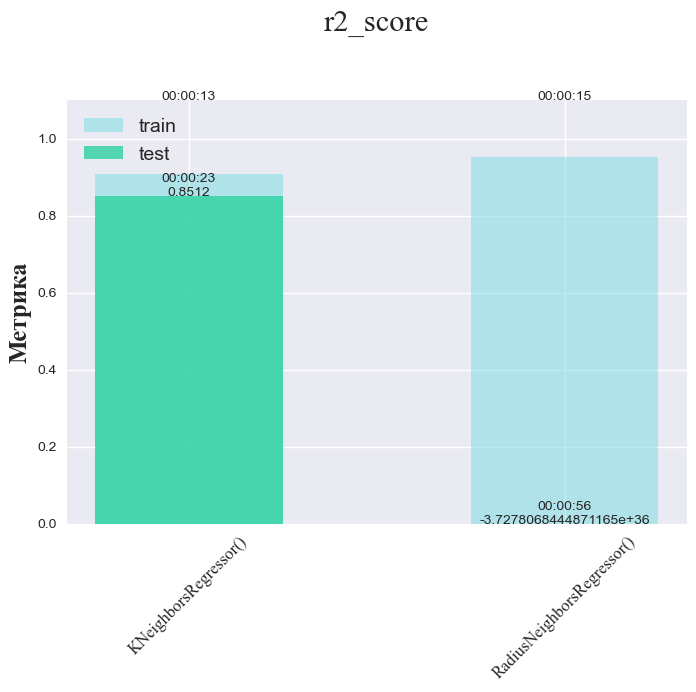

In [25]:
training_graph(models, train_times, train_scores, test_times, test_scores)

In [26]:
best_models = (DecisionTreeRegressor(), RandomForestRegressor(), KNeighborsRegressor(),
               BaggingRegressor(), ExtraTreesRegressor(), HistGradientBoostingRegressor(),
               GradientBoostingRegressor())
models, train_times, train_scores, test_times, test_scores = train_models(best_models)

Тестирования GradientBoostingRegressor: 100%|███████████████████████████████████████████| 7/7 [31:46<00:00, 272.32s/it]


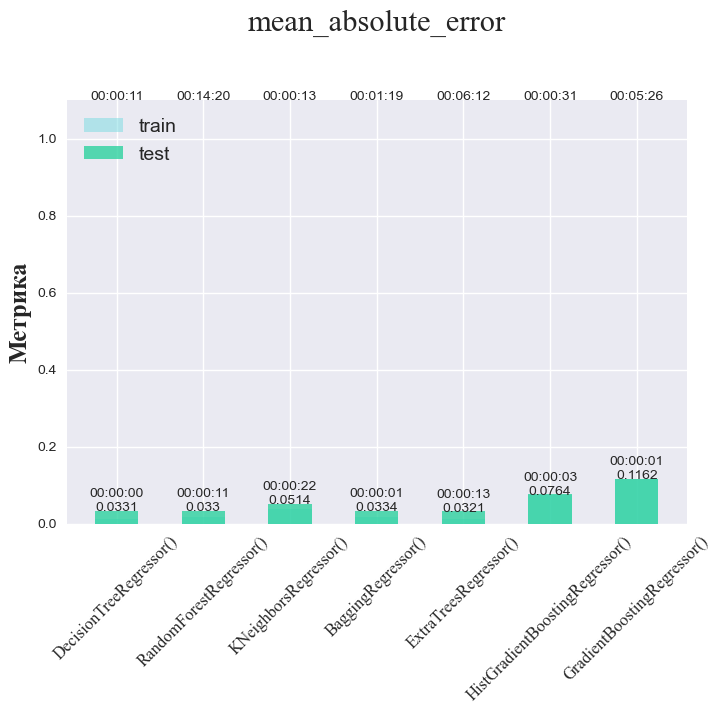

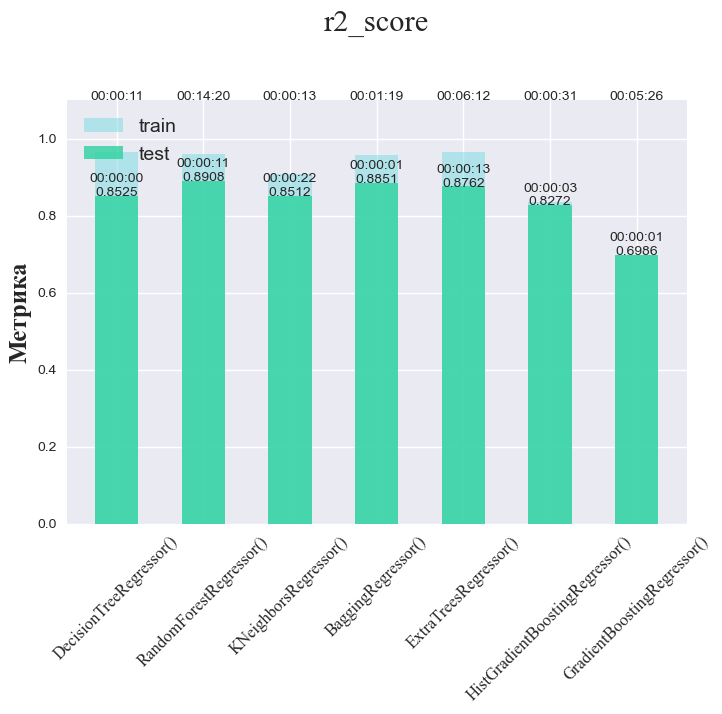

In [27]:
training_graph(models, train_times, train_scores, test_times, test_scores)